In [2]:
import torch
from ziggy.kernels import Matern, SqExp
from ziggy.misc import toeplitz_expanded
import pyprind, os
import numpy as np
import matplotlib.pyplot as plt; plt.ion()
import seaborn as sns; sns.set_style("white")
sns.set_context("paper")
sns.set(font_scale=1.15)

In [3]:
use_cuda = torch.cuda.is_available()
dtype =torch.float32
device = torch.device("cuda") if use_cuda else torch.device('cpu')
print("Using device: ", device)


output_dir = "./output-preconditioner-analysis"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Using device:  cpu


In [113]:
kerns = [SqExp(), Matern(nu=2.5), Matern(nu=1.5), Matern(nu=0.5)]

In [140]:
sig2 = 1
#ell = 0.5
ell = 0.05
kern_rslt_dict = {}
names = ["{}({},{})".format(kern, sig2, ell) for kern in ["SqExp", "Mat52", "Mat32", "Mat12"]]
for name, kern in zip(names, kerns):
    # construct kernel_fun
    xlo = 0
    xhi = 2  # 8 inducing points can cover
    # iterate over M x M grids
    num_vecs = 25
    #Ms = [25, 50, 100]
    Ms = [10, 20, 40, 80, 100, 200, 300, 400, 500]
    #Ms = [4, 10, 20, 40, 80, 100, 200, 500]
    res_dict = {}

    for Mx in Ms:
        #print("Running M x M = %d x %d (Mtotal = %d)"%(Mx, Mx, Mx*Mx))
        print("Running M = {}".format(Mx))
        x1 = torch.linspace(xlo, xhi, Mx)
        #x2 = torch.linspace(-2, 2, Mx)

        xgrids = [x1]
        M = np.prod([len(x) for x in xgrids])
        kernel = lambda x, y: kern.forward(x, y, params=(sig2, ell))
        vec    = torch.randn(num_vecs, M)
        print("Solving a system of %d variables"%M)

        def make_callback():
            xs = []
            def callback(n, x):
                #if (n > 100) and (n % 50==0):
                 #   print("  ... iter %d "%n)
                xs.append(x)
            return callback, xs

        cb_cg, xs_cg = make_callback()
        print("cg")
        res = toeplitz_expanded.gram_solve(xgrids, kernel, vec,
            do_precond=False, tol=1e-10, maxiter=2000, callback=cb_cg, mult_RT=False)

        cb_pcg, xs_pcg = make_callback()
        print("pcg")
        res_pre = toeplitz_expanded.gram_solve(xgrids, kernel, vec,
            do_precond=True, tol=1e-10, maxiter=2000, callback=cb_pcg, mult_RT=False)

        res_dict[Mx] = {"cg": xs_cg, "pcg": xs_pcg}

    num_iters_cg = np.array([len(res_dict[Mx]['cg']) for Mx in Ms])
    num_iters_pcg = np.array([len(res_dict[Mx]['pcg']) for Mx in Ms])
    pcg_frac = num_iters_pcg / num_iters_cg

    print(name)
    print("Number iters cg", num_iters_cg)
    print("number iters pcg", num_iters_pcg)
    print("\n")

    kern_rslt_dict[name] = [num_iters_cg, num_iters_pcg, pcg_frac]


Running M = 10
Solving a system of 10 variables
cg
pcg
Running M = 20
Solving a system of 20 variables
cg
pcg
Running M = 40
Solving a system of 40 variables
cg
pcg
Running M = 80
Solving a system of 80 variables
cg
pcg
Running M = 100
Solving a system of 100 variables
cg
pcg
Running M = 200
Solving a system of 200 variables
cg
pcg
Running M = 300
Solving a system of 300 variables
cg
pcg
Running M = 400
Solving a system of 400 variables
cg
pcg
Running M = 500
Solving a system of 500 variables
cg
pcg
SqExp(1,0.05)
Number iters cg [   2   11   55 2000 2000 2000 2000 2000 2000]
number iters pcg [  1   2   4  39  42  67  87 100 102]


Running M = 10
Solving a system of 10 variables
cg
pcg
Running M = 20
Solving a system of 20 variables
cg
pcg
Running M = 40
Solving a system of 40 variables
cg
pcg
Running M = 80
Solving a system of 80 variables
cg
pcg
Running M = 100
Solving a system of 100 variables
cg
pcg
Running M = 200
Solving a system of 200 variables
cg
pcg
Running M = 300
Solving a s

In [141]:
names

['SqExp(1,0.05)', 'Mat52(1,0.05)', 'Mat32(1,0.05)', 'Mat12(1,0.05)']

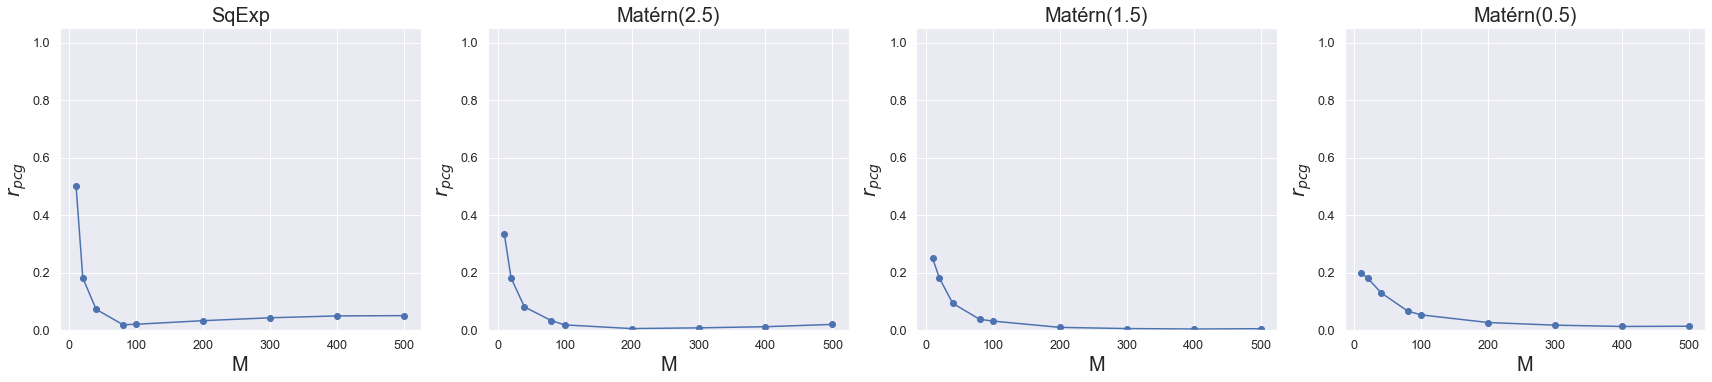

In [143]:
fig, axes = plt.subplots(1, 4, figsize=(4*6, 6))

label_names = ['SqExp', 'Matérn(2.5)', 'Matérn(1.5)', 'Matérn(0.5)']

for ax, name, label_name in zip(axes, names, label_names):
    _, _, frac_pcg = kern_rslt_dict[name]
    ax.plot(Ms, frac_pcg, '-o')
    ax.set_ylabel(r"$r_{pcg}$", fontsize=20)
    ax.set_xlabel("M", fontsize=20)
    ax.set_ylim(0,  1.0+0.05)
    ax.set_title(label_name, fontsize=20)

#fig.suptitle("sig2 = {}, ell ={}".format(sig2, ell), fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig(os.path.join(output_dir, "num-iters-vs-M-sig2={}ell={}.png".format(sig2, ell)))


In [98]:
label_names = ["SqExp", "Matérn(2.5)", "Matérn(1.5)", "Matérn(0.5)"]

In [108]:
def plot_kernel_matrix(M, ell, sig2):
    xinduce = torch.linspace(xlo, xhi, M)
    xinduce = xinduce.unsqueeze(-1)
    Kuus = []
    for kern in kerns:
        Kuu = kern(xinduce, xinduce, (sig2, ell))
        Kuus.append(Kuu)


    fig, axes = plt.subplots(1, 4, figsize=(4*6 ,6))
    plt.grid(False)
    for ax, Kuu, kernel_name in zip(axes, Kuus, kernel_names):
        im = ax.imshow(Kuu, vmin=0, vmax=1)
        fig.colorbar(im, ax=ax)
        ax.grid(False)
        ax.set_title(kernel_name, fontsize=20)

    fig.tight_layout()
    plt.savefig(os.path.join(output_dir, "kernel-comparison-sig2={}-ell{}-M{}.png".format(sig2, ell, M)))


l = 0.05

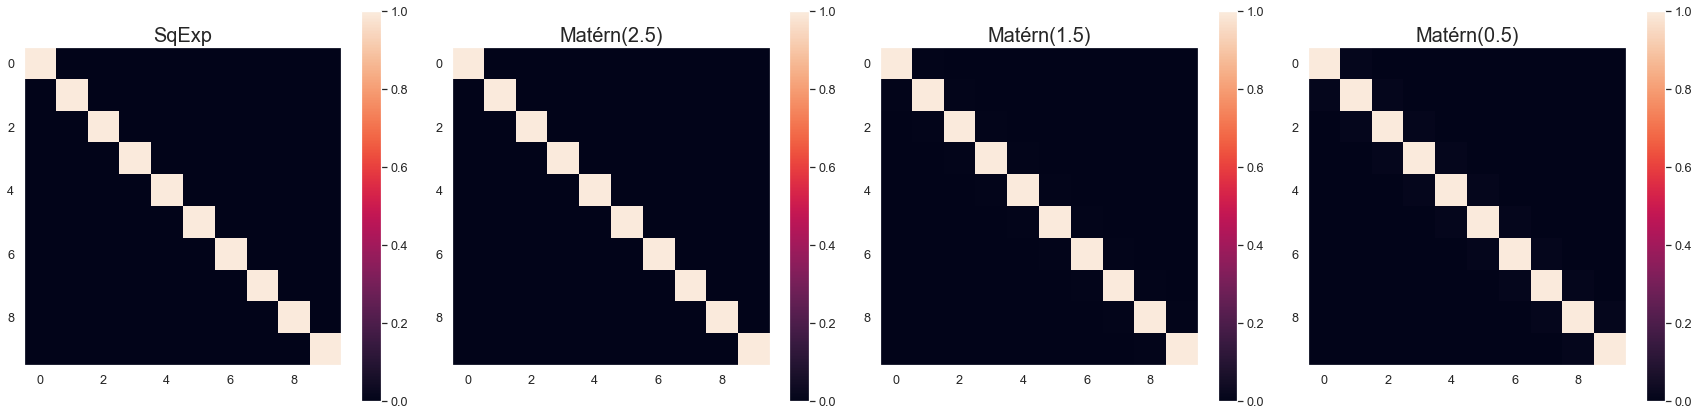

In [109]:
plot_kernel_matrix(10, ell=0.05, sig2=1.0)

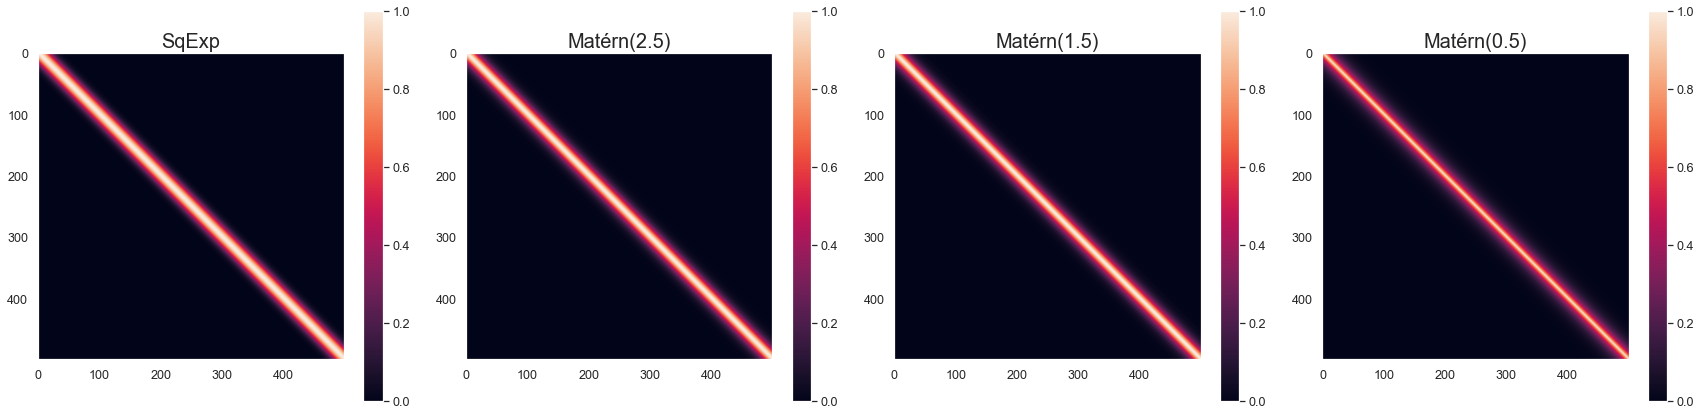

In [131]:
plot_kernel_matrix(500, ell=0.05, sig2=1.0)

l = 0.5

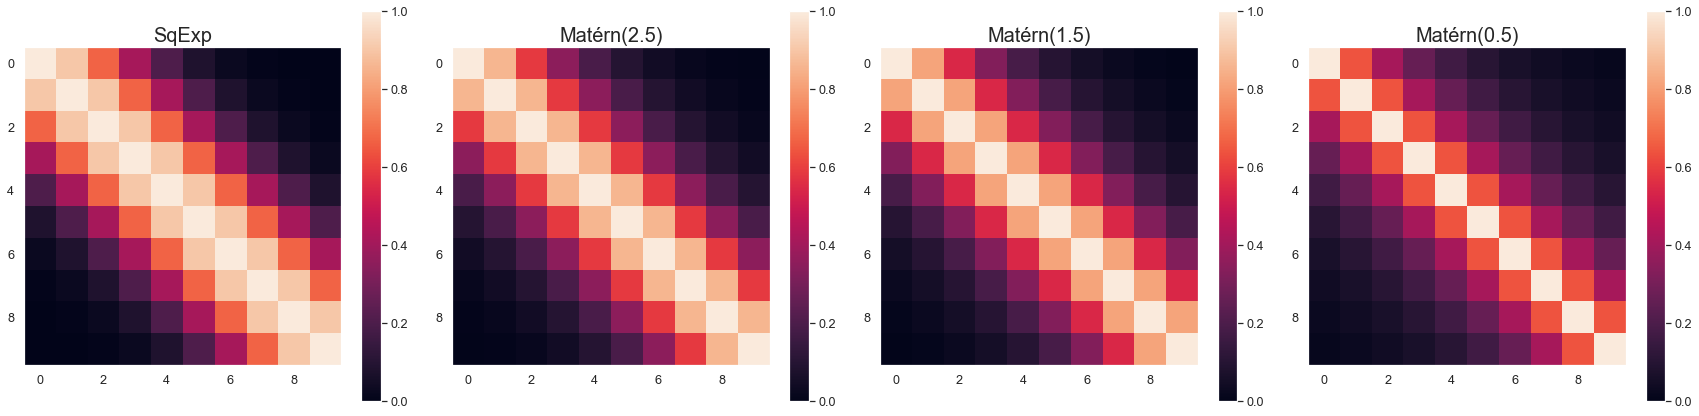

In [129]:
plot_kernel_matrix(10, ell=0.5, sig2=1.0)

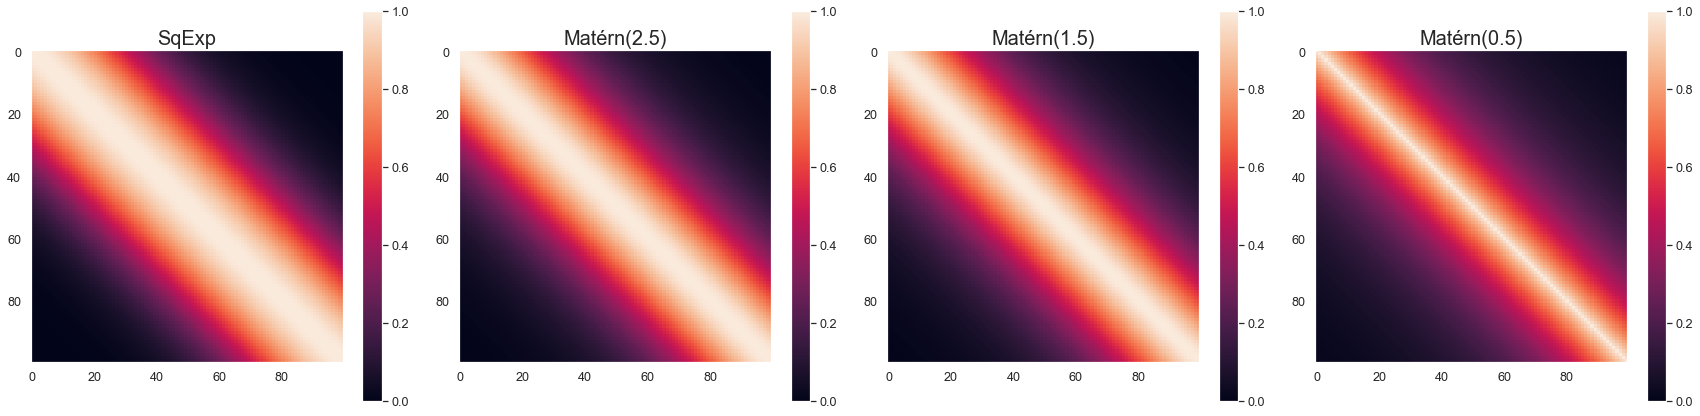

In [130]:
plot_kernel_matrix(100, ell=0.5, sig2=1.0)

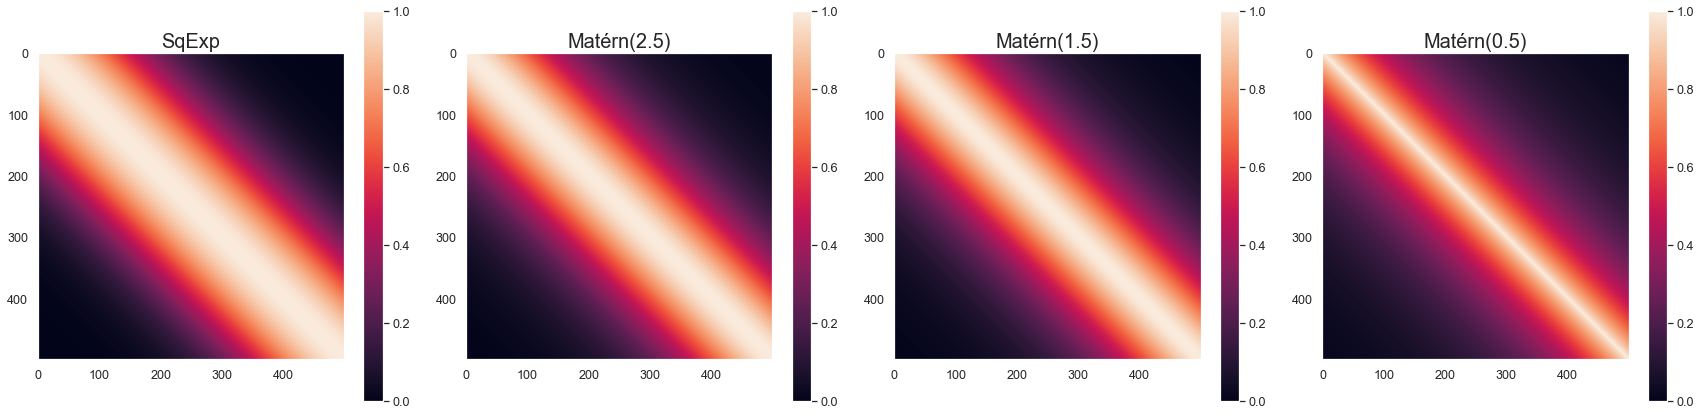

In [111]:
plot_kernel_matrix(500, ell=0.5, sig2=1.0)